# M2/MVA : Practical work on SAR statistics

### Thursday 21st of february 2019 
### Jean-Marie NICOLAS, Florence TUPIN

Images of the practical work can be found on: 
https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/

Codes of the practical work are available here:
https://perso.telecom-paristech.fr/tupin/TPSAR/PROGS

Some useful functions are available in the file *mvalab.py*. 

### Reading of images with TélécomParisTech format
A useful function to read the images with Télécom-Paristech format is *imz2mat*

### Vizualisation of an image 

The function to display a SAR image with an adapted thresholding of the values is 
*visusar*. the first argument containing the image is compulsary, and the second one is 
optional and corresponds to a threshold for the display. 
The value $\alpha$ defines the threshold in this way :

${\rm thres} \:\:=\:\: {\rm vmean} \:\: + \:\: \alpha \: {\rm std}$


vmean is the mean value and std the standard deviation computed on the whole image. Every pixel whose value is above this threshold is displayed with the maximal value.  

When $\alpha$ is 0, the image is displayed with the full dynamic range.
A usual value to display SAR images is 3. 

### Study of homogeneous areas

You have at your disposal a set of images coming from different sensors and with different characteristics on the same area of Flevoland in Netherlands (for each sensor and acquisition mode, an homogeneous area of sea has been selected with *mer* extension, and an area of farmland with  *centre* extension):
- Sentinel-1 sensor (ESA), SLC (Single look Complex) data and GRD (Ground Range Detected) data ;
- ERS sensor (ESA), PRI product (ground range data);
- Alos sensor (JAXA), SLC (Single look Complex) data.

Using an SLC data, check that the sea area follows the distributions given during the course for fully developped speckle by computing the histograms (for phase, real part, imaginary part, intensity and amplitude data). Compute the values of the first moments and the coefficient of variation and comment their values.   

In [ ]:
In the below work, you can see the histograms to the theoretical distributions. You can see a resonable fit, modulo
some clustering or "bunching up" of values, particularly present in the real and imaginary parts. The coefficient of variation
is not far from the 0.523 figure from the Goodman model

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_mer.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_mer.dim
lecture .dim OK -> largeur:512 hauteur:512 profondeur:1
Debug 2 2 512
2 512 >h
Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 512 x 512


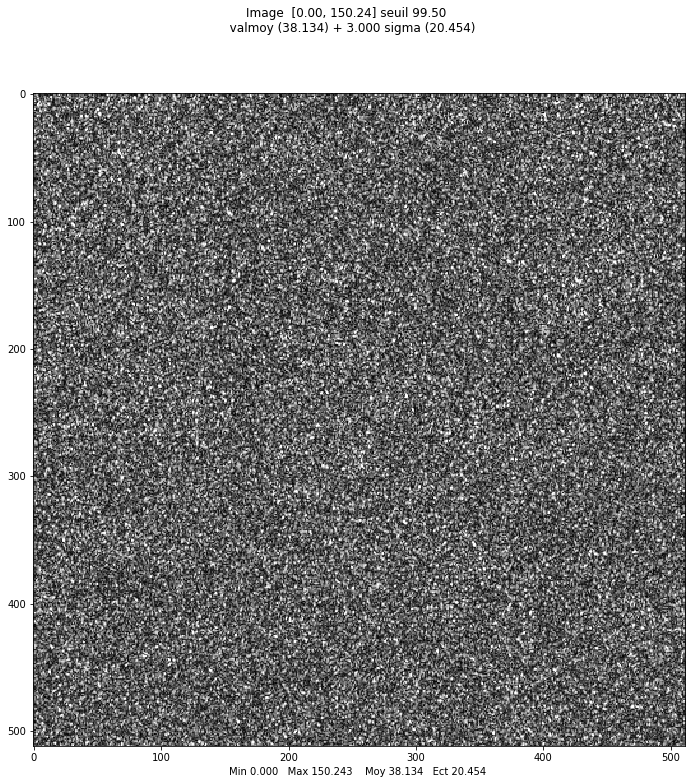

REAL MEAN: -0.020252227783203125
REAL STD: 30.616986373372217
-1511.7836270222804
IMAG MEAN -0.015869140625
IMAG STD: 30.580710634589078
-1927.0552424504133


/home/maxdunitz/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


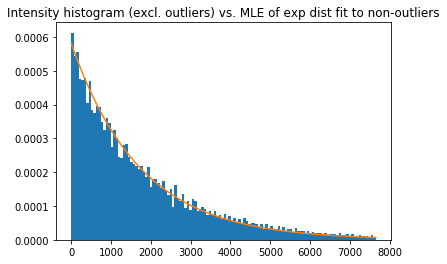

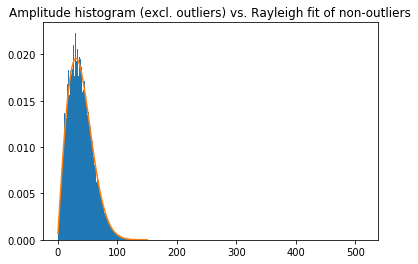

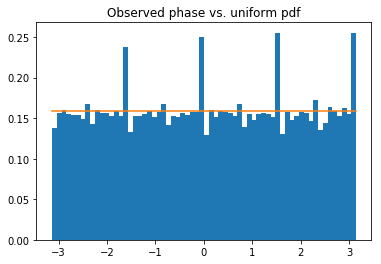

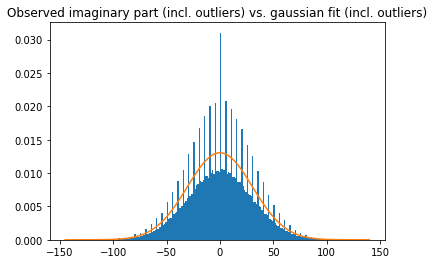

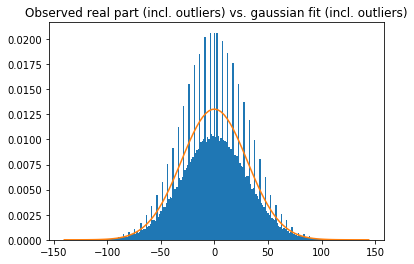

MEAN (amplitude): 38.134292201390934
STD (amplitude): 20.453756080119334
COEFF_VAR (computed from amplitude): 0.5363612355016594


In [48]:
import math
import numpy as npy
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.stats import gamma, expon, rayleigh, norm
import numpy as np

import numpy

import mvalab

tagnotebook=1
mvalab.notebook(tagnotebook)

pageweb="https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/"
image='SentinelSLC_flevoland_mer.cxs'
im_slc_senti_mer_liste=mvalab.imz2mat(pageweb+image);
im_slc_senti_mer = im_slc_senti_mer_liste[0]
ncol=im_slc_senti_mer_liste[1]
nlig=im_slc_senti_mer_liste[2]

mvalab.visusar(im_slc_senti_mer)

#%%

amp_slc_senti_mer=numpy.abs(im_slc_senti_mer);
int_slc_senti_mer=numpy.multiply(amp_slc_senti_mer,amp_slc_senti_mer);
ph_slc_senti_mer=numpy.angle(im_slc_senti_mer);
real_slc_senti_mer=numpy.real(im_slc_senti_mer);
imag_slc_senti_mer=numpy.imag(im_slc_senti_mer);

#fit_alpha, fit_loc, fit_beta = gamma.fit(data)

# Intensity fit (exponential assuming jointly Gaussian noise in real and imaginary channels for single-look)
int_slc_senti_mer_vec = int_slc_senti_mer.reshape((ncol*nlig,))
seuil_int = np.mean(int_slc_senti_mer_vec) + 3*np.std(int_slc_senti_mer_vec)
int_slc_senti_mer_vec = int_slc_senti_mer_vec[int_slc_senti_mer_vec <= seuil_int]
exponential_fit_lambda = 1.0/np.mean(int_slc_senti_mer_vec) #MLE estimate
xmin_i = np.min(int_slc_senti_mer_vec)
xmax_i = np.mean(int_slc_senti_mer_vec)
x_i = np.linspace(xmin_i, seuil_int, 1000)
exp_pdf = exponential_fit_lambda * np.exp(-1.0*exponential_fit_lambda*x_i)

# Amplitude fit 
amp_slc_senti_mer_vec = amp_slc_senti_mer.reshape((ncol*nlig,))
seuil_amp = np.mean(int_slc_senti_mer_vec) + 3*np.std(int_slc_senti_mer_vec)
amp_slc_senti_mer_vec = amp_slc_senti_mer_vec[amp_slc_senti_mer_vec <= seuil_amp]
rloc, rscale = rayleigh.fit(amp_slc_senti_mer_vec)
xmin_a = np.min(amp_slc_senti_mer_vec)
xmax_a = np.max(amp_slc_senti_mer_vec)
x_a = np.linspace(xmin_a, xmax_a, 100)
ray_pdf = rayleigh.pdf(x_a, loc=rloc, scale=rscale)

# Phase fit (uniform 1/(2pi), uninformed by the data)
phase = ph_slc_senti_mer.reshape((ncol*nlig,))
x_unif = np.linspace(-1.0*math.pi, math.pi, 100)
unif_pdf = (1.0/(2*math.pi))*np.ones(x_unif.shape)

# Real fit
real = real_slc_senti_mer.reshape((ncol*nlig,))
mean_ = np.mean(real)
std_ = np.std(real)
print("REAL MEAN:", mean_)
print("REAL STD:", std_)
print(std_/mean_)
x_real = np.linspace(np.min(real), np.max(real), 100)
real_pdf = norm.pdf(x_real, loc=mean_, scale=std_)

# Imag fit
imag = imag_slc_senti_mer.reshape((ncol*nlig,))
std_ = np.std(imag)
mean_ = np.mean(imag)
print("IMAG MEAN", mean_)
print("IMAG STD:", std_)
print(std_/mean_)
x_imag = np.linspace(np.min(imag), np.max(imag), 100)
imag_pdf = norm.pdf(x_imag, loc=mean_, scale=std_)

plt.hist(int_slc_senti_mer_vec,bins='auto',normed=True, range=[0,seuil_int])  # 512 sera la valeur max
plt.plot(x_i, exp_pdf)
plt.title("Intensity histogram (excl. outliers) vs. MLE of exp dist fit to non-outliers")
plt.show()  

plt.hist(amp_slc_senti_mer_vec,bins='auto',normed=True,range=[0.,512])  # 512 sera la valeur max
plt.plot(x_a, ray_pdf)
plt.title("Amplitude histogram (excl. outliers) vs. Rayleigh fit of non-outliers")
plt.show()  

plt.hist(phase,bins='auto',normed=True)
plt.plot(x_unif, unif_pdf)
plt.title("Observed phase vs. uniform pdf")
plt.show()  


plt.hist(imag,bins='auto',normed=True)#True,range=[0.,512])  # 512 sera la valeur max
plt.plot(x_imag, imag_pdf)
plt.title("Observed imaginary part (incl. outliers) vs. gaussian fit (incl. outliers)")
plt.show()  

plt.hist(real,bins='auto',normed=True)
plt.plot(x_real, real_pdf)
plt.title("Observed real part (incl. outliers) vs. gaussian fit (incl. outliers)")
plt.show()  


m_A=numpy.mean(amp_slc_senti_mer)
sigma_A=numpy.std(amp_slc_senti_mer)
coeff_var_A=sigma_A/m_A

print("MEAN (amplitude):", m_A)
print("STD (amplitude):", sigma_A)
print("COEFF_VAR (computed from amplitude):", coeff_var_A)

### Multi-looking

A common way to reduce the speckle is to multi-look the data.

#### Computation of the Equivalent Number of looks
Use the value of the coefficient of variation to find the number of looks of the Sentinel GRD and ERS data. 
The formula is :
- $\gamma_I=\frac{1}{\sqrt{L}}$ for intensity data 
- $\gamma_A=\frac{0.523}{\sqrt{L}}$

Comment the number of looks you have found for GRD and ERS data. 



In [30]:
image='SentinelGRD_flevoland_mer.imw'
im_senti_GRD_mer=mvalab.imz2mat(pageweb+image)
#mvalab.visusar(numpy.abs(im_senti_GRD_mer[0]))

im_slc_senti_GRD_mer = im_senti_GRD_mer[0].reshape((im_senti_GRD_mer[1]*im_senti_GRD_mer[2],))
amp_slc_senti_GRD_mer=numpy.abs(im_slc_senti_GRD_mer)
int_slc_senti_GRD_mer=numpy.abs(im_slc_senti_GRD_mer)**2
coeff_I = np.std(int_slc_senti_GRD_mer)/np.mean(int_slc_senti_GRD_mer)
coeff_A = np.std(amp_slc_senti_GRD_mer)/np.mean(amp_slc_senti_GRD_mer)
print("ENL of Sentinel GRD (computed from intensity): ", 1.0/np.square(coeff_I))
print("ENL of Sentinel GRD (computed from amplitude): ", 0.523**2/np.square(coeff_A))

image='ERS_flevoland_mer.imw'
im_slc_senti_GRD_mer=mvalab.imz2mat(pageweb+image) # pardon the incorrect variable names, I copy and pasted from above
#mvalab.visusar(numpy.abs(im_ERS_mer[0]))
im_slc_senti_GRD_mer = im_slc_senti_GRD_mer[0].reshape((im_slc_senti_GRD_mer[1]*im_slc_senti_GRD_mer[2],))
amp_slc_senti_GRD_mer=numpy.abs(im_slc_senti_GRD_mer)
int_slc_senti_GRD_mer=numpy.abs(im_slc_senti_GRD_mer)**2
coeff_I = np.std(int_slc_senti_GRD_mer)/np.mean(int_slc_senti_GRD_mer)
coeff_A = np.std(amp_slc_senti_GRD_mer)/np.mean(amp_slc_senti_GRD_mer)
print("ENL of ERS data (computed from intensity): ", 1.0/np.square(coeff_I))
print("ENL of ERS data (computed from amplitude): ", 0.523**2/np.square(coeff_A))



imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelGRD_flevoland_mer.imw
Nom compatible url
Nom compatible url
Unsigned short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelGRD_flevoland_mer.dim
lecture .dim OK -> largeur:512 hauteur:512 profondeur:1
Debug 1 2 512
2 512 >H
ENL of Sentinel GRD (computed from intensity):  4.411329699276713
ENL of Sentinel GRD (computed from amplitude):  4.792403800535571
imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/ERS_flevoland_mer.imw
Nom compatible url
Nom compatible url
Unsigned short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/ERS_flevoland_mer.dim
lecture .dim OK -> largeur:512 hauteur:512 profondeur:1
Debug 1 2 512
2 512 >H
ENL of ERS data (computed from intensity):  2.421047244105231
ENL of ERS d

#### Multi-looking of data

Compute a multi-look down-sampled image of the Alos SLC data using a vertical factor of 4 in the vertical direction and 1 in horizontal (this will give almost square pixels).

Do the same with the SLC Sentinel image using an horizontal factor of 4 and a vertical one of 1.

Comment the effect of multi-looking. 



/home/maxdunitz/Desktop/MVA/remotesensing/TP5/images/Alos_flevoland_centre.cxf
imz2mat : version janvier 2018.  Fichier à ouvrir : /home/maxdunitz/Desktop/MVA/remotesensing/TP5/images/Alos_flevoland_centre.cxf
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .cxf
image en .cxf
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
image en float 512   2048   canaux: 1  verif :  1
lecture de  /home/maxdunitz/Desktop/MVA/remotesensing/TP5/images/Alos_flevoland_centre.cxf  en quelconque 512 2048 1  offset  0 >f 4  complex 1 blocksize 8388608
Données complexes (standard). Nouvelle version de imz2mat  >f
Pas de visualisation : Tableau manifestement beaucoup trop petit (5) pour etre une image : pas daffichage
Affichage d'une image reelle
plt.show dans visusar : image 128 x 2048


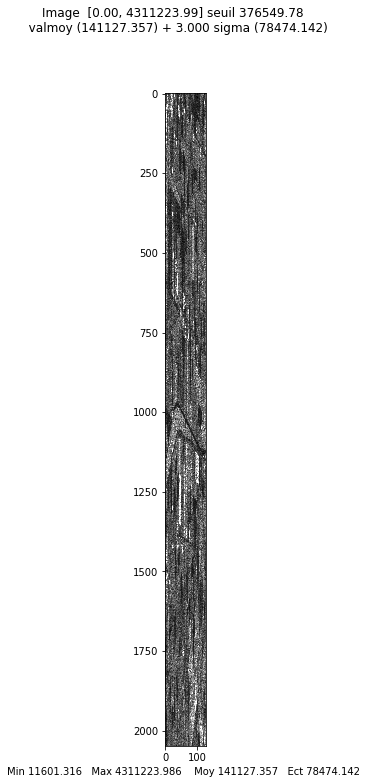

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


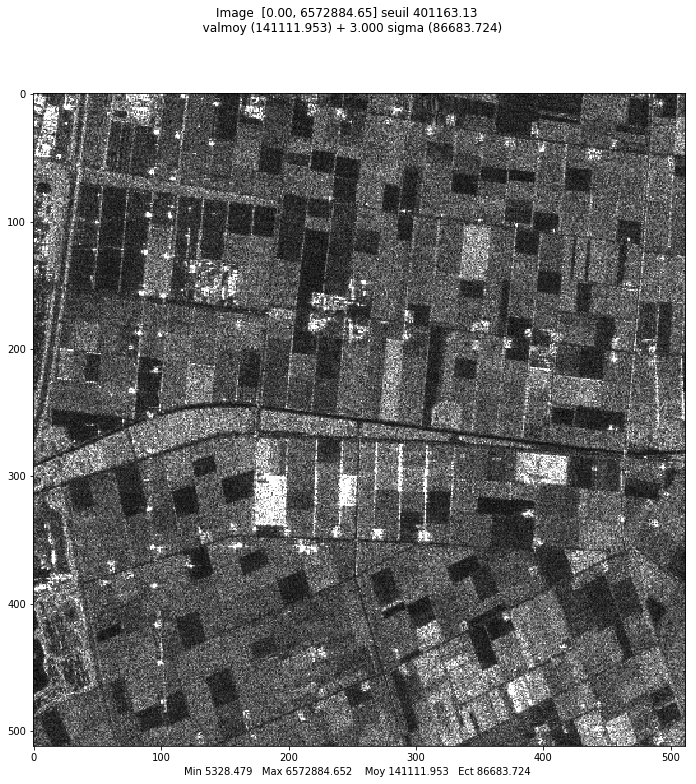

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [40]:
# WARNING to read cxf image you can not use the url 
# you have to copy the image locally on your computer
import os

image=os.getcwd()+'/images/Alos_flevoland_centre.cxf'
print(image)
im_alos_centre=mvalab.imz2mat(image)
im = np.abs(im_alos_centre)
mvalab.visusar(im)
im = np.abs(im_alos_centre[0])

from scipy.ndimage import uniform_filter

#average
im_vert = uniform_filter(im, size=(4,1))
im_horiz = uniform_filter(im, size=(1,4))

#downsample
im_vert = im_vert[::4,:]
im_horiz = im_horiz[:,::4]

mvalab.visusar(im_horiz)
mvalab.visusar(im_vert)
plt.figure()
#%%

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 512 x 512


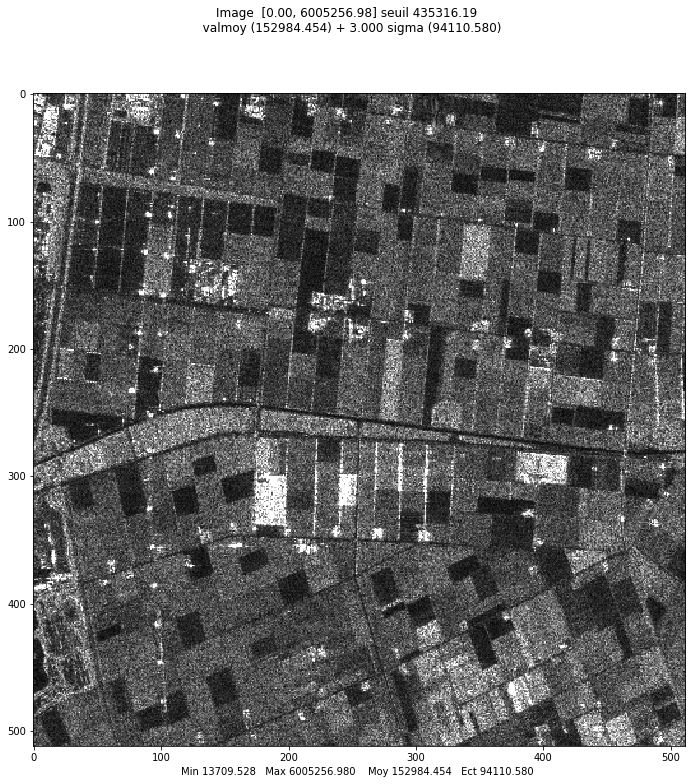

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 512 x 512


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

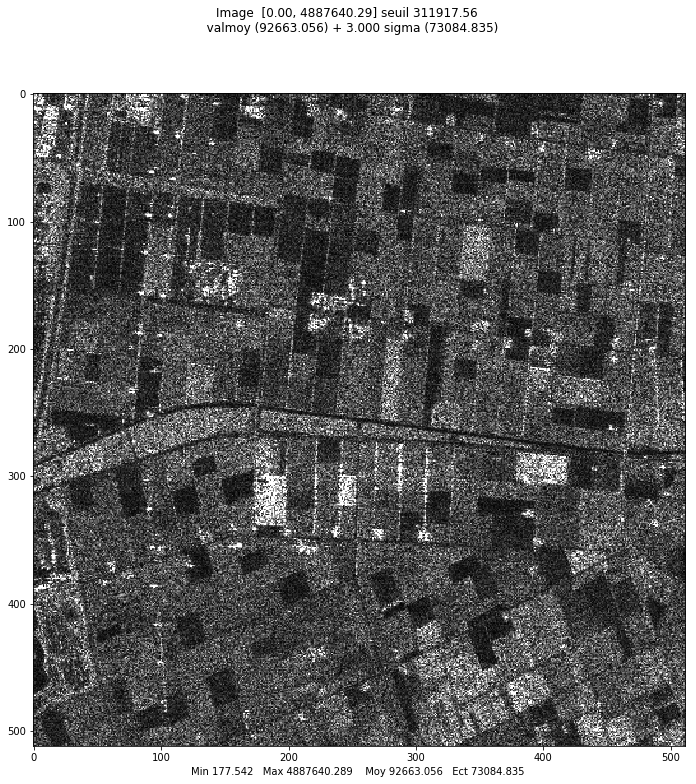

Text(0.5,0.98,'ALOS : Multivue en amplitude')

<Figure size 432x288 with 0 Axes>

In [49]:
masque_vert=numpy.ones((4,1))/4
alos_ml_int=signal.convolve2d(numpy.multiply(im_alos_centre[0], numpy.conj(im_alos_centre[0])), masque_vert,mode='same')
alos_ml_ssech_int=alos_ml_int[1:2048:4,:]
mvalab.visusar(numpy.sqrt(alos_ml_ssech_int)) 
plt.suptitle(u'ALOS : Multivue en intensité')

#% multi-look in amplitude 
plt.figure()
alos_ml_amp=signal.convolve2d(im_alos_centre[0], masque_vert,mode='same')

alos_ml_ssech_amp=alos_ml_amp[0:2048:4,:]   # attention : syntaxe différente de matlab
mvalab.visusar(alos_ml_ssech_amp)   
plt.suptitle(u'ALOS : Multivue en amplitude')
#%%


imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelGRD_flevoland_centre.imw
Nom compatible url
Nom compatible url
Unsigned short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelGRD_flevoland_centre.dim
lecture .dim OK -> largeur:512 hauteur:512 profondeur:1
Debug 1 2 512
2 512 >H
Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


<Figure size 432x288 with 0 Axes>

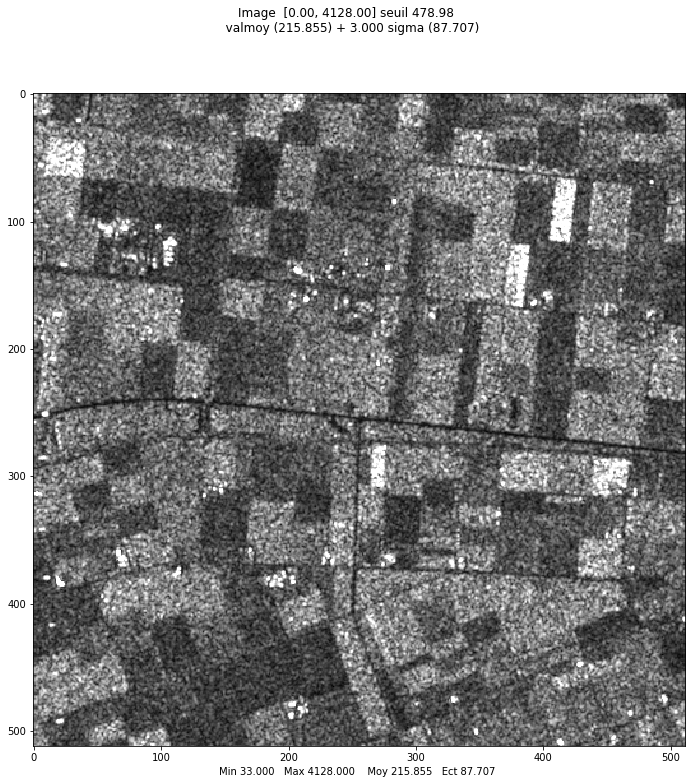

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_centre.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_centre.dim
lecture .dim OK -> largeur:2048 hauteur:512 profondeur:1
Debug 2 2 2048
2 2048 >h
Affichage d'une image reelle
plt.show dans visusar : image 2048 x 512


<Figure size 432x288 with 0 Axes>

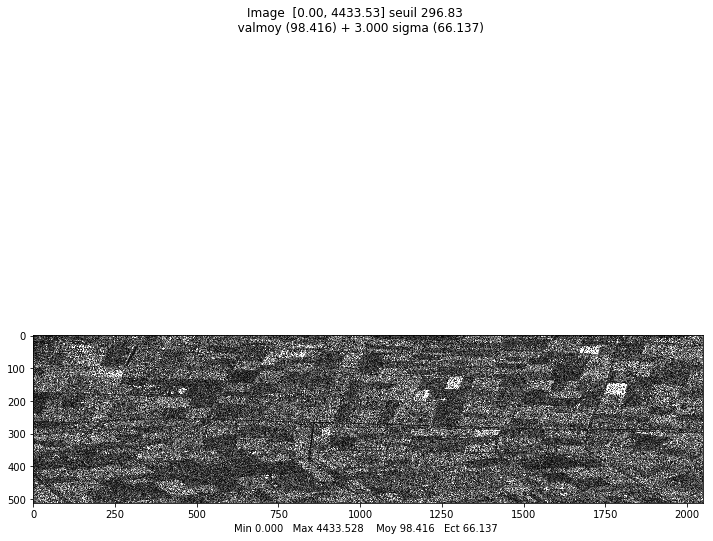

array([[ 12.52996409,  39.11521443,  59.48108943, ...,  43.28972164,
         63.07138812,  11.40175425],
       [ 48.37354649,  40.01249805,  33.52610923, ..., 109.73149047,
         63.13477647,  73.        ],
       [ 81.0061726 ,  67.67569726,  29.68164416, ..., 190.00263156,
        107.91200119, 158.82380174],
       ...,
       [105.07616285, 186.45374762, 125.39936204, ...,  40.36087214,
         37.57658846,  67.89698079],
       [ 35.4682957 , 100.65783626, 111.87939935, ...,  38.07886553,
         44.28317965, 117.03418304],
       [260.24987992, 206.88644228,  29.15475947, ...,  45.01110974,
         70.17834424, 160.2279626 ]])

In [50]:


image='SentinelGRD_flevoland_centre.imw'
plt.figure()
im_sentigrd_centre=mvalab.imz2mat(pageweb+image)
mvalab.visusar(numpy.abs(im_sentigrd_centre[0])) # mode Z : le plt.figure et le plt.show ne seront pas effectués
plt.suptitle(u'Sentinel-1 GRD')
#plt.figure()


image='SentinelSLC_flevoland_centre.cxs'
im_sentislc_centre=mvalab.imz2mat(pageweb+image)
mvalab.visusar(numpy.abs(im_sentislc_centre[0])) # mode Z : le plt.figure et le plt.show ne seront pas effectués
#plt.suptitle(u'Sentinel-1 GRD')

#do the multilooking downsampled using an horizontal factor of 4 and a vertical one of 1.






## Coefficient of variation

This coefficient (ratio between standard deviation by mean) is an indication of the local homogeneity of the scene. 


Using 2D convolution to speed up the processing, compute the images of coefficient of variation. Comment the results (which structures of the image are highlighted ?) and the influence of the window size.  


imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_centre.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/DATA/images/SentinelSLC_flevoland_centre.dim
lecture .dim OK -> largeur:2048 hauteur:512 profondeur:1
Debug 2 2 2048
2 2048 >h
Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


<Figure size 432x288 with 0 Axes>

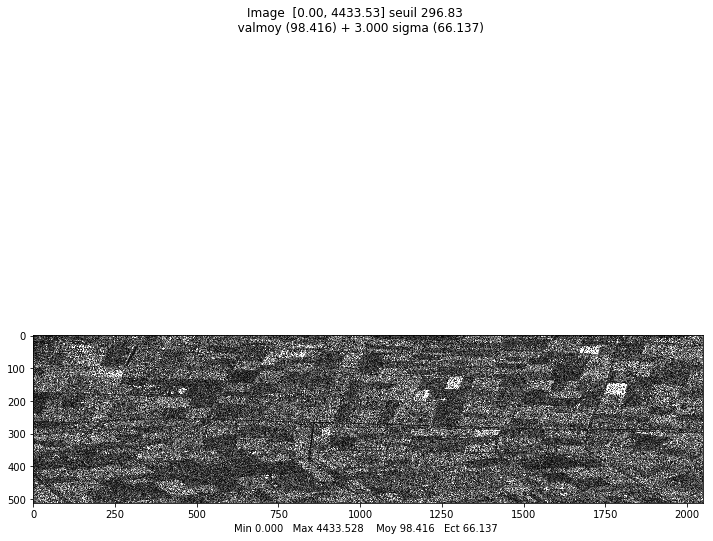

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


<Figure size 432x288 with 0 Axes>

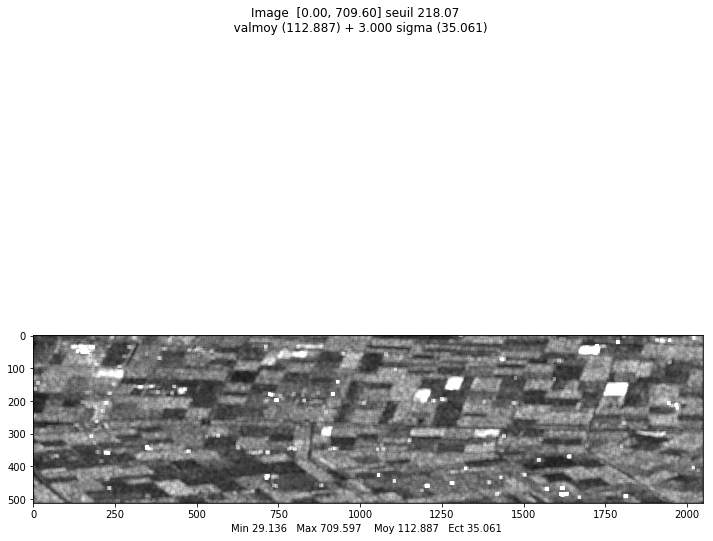

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


<Figure size 432x288 with 0 Axes>

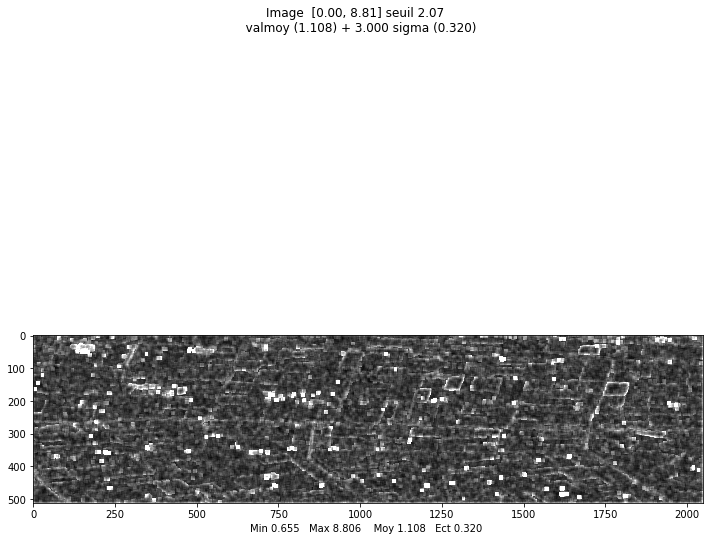

array([[2.06846495, 2.06846495, 2.06846495, ..., 1.88092336, 1.98089849,
        2.06846495],
       [2.06846495, 2.06846495, 2.04683607, ..., 1.69600338, 1.78009893,
        1.96270841],
       [2.06846495, 2.06611108, 1.85146076, ..., 1.57698955, 1.65309869,
        1.83065104],
       ...,
       [2.02739186, 1.87804884, 1.72620334, ..., 1.58871632, 1.710858  ,
        1.88550618],
       [2.06846495, 2.06133736, 1.92688721, ..., 1.73885487, 1.84554378,
        2.00612676],
       [2.06846495, 2.06846495, 2.06846495, ..., 1.94277254, 2.03583359,
        2.06846495]])

In [51]:
image='SentinelSLC_flevoland_centre.cxs'
im_slc_senti_centre=mvalab.imz2mat(pageweb+image)
ima_int=numpy.multiply(im_slc_senti_centre[0], numpy.conj(im_slc_senti_centre[0]))

size_window=11;
masque_loc=numpy.ones((size_window,size_window))/(size_window*size_window)
ima_intcarre=numpy.multiply(ima_int,ima_int)

ima_int_mean=signal.convolve2d(ima_int, masque_loc,mode='same')
plt.figure(1);
mvalab.visusar(numpy.sqrt(ima_int));

plt.figure(2);
mvalab.visusar(numpy.sqrt(ima_int_mean));

ima_int_mean_carre=signal.convolve2d(ima_intcarre, masque_loc,mode='same')
ima_variance=ima_int_mean_carre-numpy.multiply(ima_int_mean,ima_int_mean)
ima_coeff_var=numpy.divide(numpy.sqrt(ima_variance),ima_int_mean)


plt.figure(3);
mvalab.visusar(ima_coeff_var)

## Lee filter

This local coefficient is also used in a very famous filter for SAR images: Lee filter. 
The principle of the filter is to combine the pixel value $I_s$ (intensity value of pixel $s$) and the local mean $\hat{\mu}_{s}$ depending on the local coefficient of variation $\hat{\gamma}_s$ with the following formula :
$
  \hat{I}_s= \hat{\mu}_{s}+k_s (I_s-\hat{\mu}_{s})
$

and
$
  k_s=1- \frac{\gamma_S}{\hat{\gamma}_s}
$

$\gamma_S$ is the theoretical value of the coefficient of variation for a pure speckle ($\gamma_S=\frac{1}{\sqrt{L}}$ for a L-look intensity image).

Using the previous map, compute the resulting image with Lee filter. Comment the result and compare with a local mean. 

Warning : $k$ should be in $[0,1]$. 



(0.49081215215394836+0j)
(0.9621483320554803+0j)
Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


<Figure size 432x288 with 0 Axes>

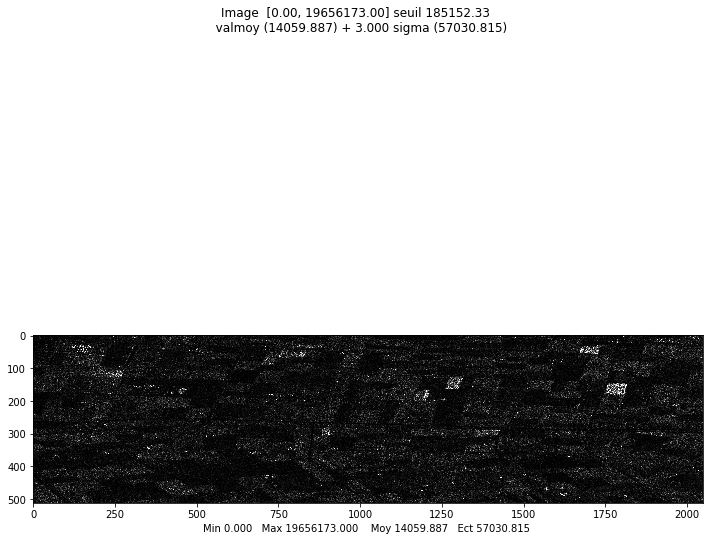

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


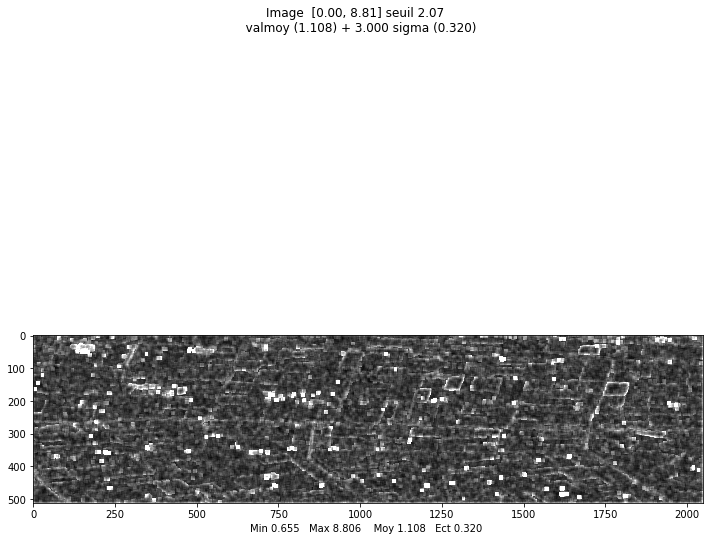

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 512


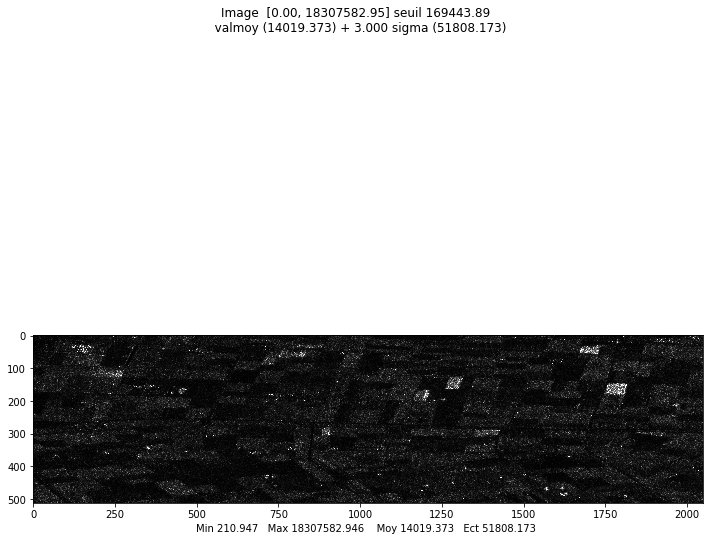

array([[  344.10432369,  1529.41308817,  3249.9951085 , ...,
         2973.15975537,  4602.70886514,  1040.11022697],
       [ 2285.05692152,  1663.48566627,  1304.77352599, ...,
        11465.09900979,  4872.49234763,  5575.93768333],
       [ 5873.61723848,  4194.93647234,  1171.65873986, ...,
        30535.24657575, 11187.14876276, 21961.8516408 ],
       ...,
       [10164.81830309, 29912.20694994, 14248.28988573, ...,
         2297.69656357,  2003.07004443,  4499.15881702],
       [ 1852.91753209,  9589.86619831, 11603.06218183, ...,
         1943.82900581,  2293.82015042, 11995.00037282],
       [59054.74062787, 37405.65854945,  1756.44733532, ...,
         2282.17729585,  4669.24620021, 22243.96592162]])

In [55]:
m,n = np.shape(ima_coeff_var)

window_M = 3
window_N = 3
L = window_M * window_N

gamma_s = 1 / numpy.sqrt(L)

k_s = 1 - (gamma_s * npy.ones((m,n))) / ima_coeff_var
print(np.min(k_s))
print(np.max(k_s))
           
I_s_hat = ima_int_mean + k_s * (ima_int - ima_int_mean)

plt.figure();
mvalab.visusar(ima_int)
mvalab.visusar(ima_coeff_var)
mvalab.visusar(I_s_hat)